In [7]:
import torch

# assert torch.cuda.is_available()

from deepxdeAbeta import deepxde as dde

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint
import os
import shutil
import time

In [8]:
backend = "pytorch"

In [9]:
dde.config.set_default_float("float64")
dde.backend.set_default_backend(backend)

Set the default float type to float64
Setting the default backend to "pytorch". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [10]:
max_time = 10
num_rows = 200

In [11]:
def to_npz(filepath, out_path, x_cols, y_cols):
    df = pd.read_csv(filepath)
    t = []
    y = []
    for _, v in df.iterrows():
        t.append(v[x_cols].to_numpy())
        y.append(v[y_cols].to_numpy())
    np.savez(out_path, t=t, y=y)


def load_training_data(data_path):
    tr_data = np.load(data_path)
    return tr_data['t'], tr_data['y']

In [12]:
geom = dde.geometry.TimeDomain(0, max_time)


# Helper function that is used to check whether a point is an initial point or not. This is only used by DeepXDE
def boundary(_, on_initial):
    return on_initial


num_hidden_layers = 3
hidden_layer_size = 128
output_layer = 3

layers = [1] + [hidden_layer_size] * num_hidden_layers + [output_layer]

activation = ['tanh']*num_hidden_layers + ['tanh']

iterations = 35_000
optimizer = "adam"
learning_rate = 1e-03

In [13]:
model_num = 5 #TODO
model_dir = 'binning_trials/models/model' + str(model_num)
datafile = 'binning_trials/model' + str(model_num) + '.csv'

In [14]:
#IMPORTS
# from binning_trials.binned_models import *
a1, a2, a3, a4 = [dde.Variable(np.float64(0)), dde.Variable(np.float64(0)), dde.Variable(np.float64(0)), dde.Variable(np.float64(0))]
n, m = np.float64(2/1.2), np.float64(2)
def equations(x, y):
    # print(y)
    B1_2, B2, B4 = abs(y[:, 0:1]), abs(y[:, 1:2]), abs(y[:, 2:3])
    # tf.print(x, output_stream=sys.stderr, summarize=10)

    B1_2t = dde.grad.jacobian(y, x, i=0)
    B2t = dde.grad.jacobian(y, x, i=1)
    B4t = dde.grad.jacobian(y, x, i=2)
    # print(B1_35)

    # calculates residuals by subtracting right side from left side of each equation.
    # Left side is calculated with respect to time, right side is calculated with the other species.
    # Finding the correct constants to make residuals = 0; essentially residual = loss to be minimized.
    r_b1_2 = B1_2t - (a1 * n * B2 - a2 * n * B1_2**n)
    r_b2 = B2t - (a2 * B1_2**n - a1 * B2 + a3 * m * B4 - a4 * m * B2**m)
    r_b4 = B4t - (a4 * B2**m - a3 * B4)


    # print(r_b1_35)

    # res = torch.cat([r_b1, r_b1p, r_bn, r_bnp, r_bm, r_bmp])
    # diff = torch.cat([B1t, B1pt, Bnt, Bnpt, Bmt, Bmpt])
    # pred = torch.cat([B1tp, B1ptp, Bntp, Bnptp, Bmtp, Bmptp])
    # res2 = torch.where(pred < 0, res*100, res)
    # # print(res[torch.ge(res, diff)])
    #
    # return torch.chunk(res, 6)

    return [r_b1_2, r_b2, r_b4]
initial_conditions = [2.02E-06,5.42E-06,2.39E-05]
y_cols = ['1.2uM', '2uM', '4uM']

In [15]:
a1.dtype

torch.float64

Compiling model...
'compile' took 0.000154 s

Training model...

Step      Train loss                                                                Test loss                                                                 Test metric
0         [2.62e-03, 1.64e-02, 8.11e-03, 4.08e-12, 2.94e-11, 2.62e-01, 2.67e-02]    [2.62e-03, 1.64e-02, 8.11e-03, 4.08e-12, 2.94e-11, 2.62e-01, 2.67e-02]    []  
350       [1.31e-03, 4.68e-03, 1.37e-04, 4.02e-07, 1.30e-04, 1.82e-03, 1.02e-02]    [1.31e-03, 4.68e-03, 1.37e-04, 4.02e-07, 1.30e-04, 1.82e-03, 1.02e-02]    []  
700       [9.16e-04, 4.29e-03, 5.64e-04, 6.41e-07, 1.83e-04, 8.98e-04, 7.26e-03]    [9.16e-04, 4.29e-03, 5.64e-04, 6.41e-07, 1.83e-04, 8.98e-04, 7.26e-03]    []  
1050      [8.77e-04, 4.23e-03, 7.92e-04, 8.29e-07, 1.77e-04, 7.45e-04, 6.61e-03]    [8.77e-04, 4.23e-03, 7.92e-04, 8.29e-07, 1.77e-04, 7.45e-04, 6.61e-03]    []  
1400      [8.66e-04, 3.92e-03, 1.14e-03, 8.32e-07, 1.58e-04, 6.92e-04, 5.99e-03]    [8.66e-04, 3.92e-03, 1.14e-03

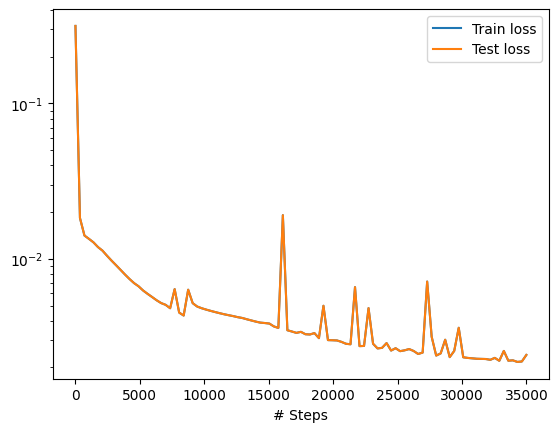

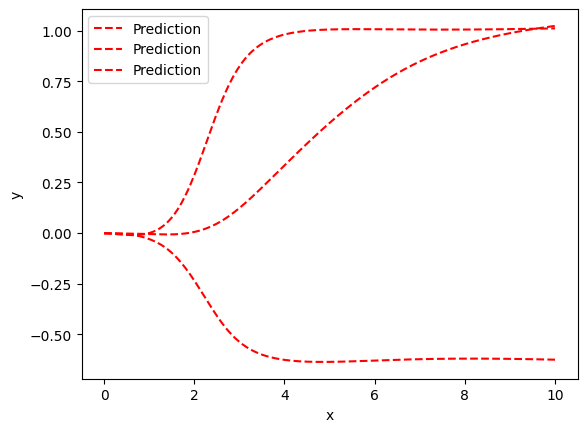

In [16]:
variable = dde.callbacks.VariableValue(
    [a1, a2, a3, a4],
    period=(iterations//100 if iterations > 99 else 1),
    filename=model_dir+'/variables.dat')

start = time.time()

to_npz(datafile, 'model' + str(model_num) + '.npz', x_cols=['t'], y_cols=y_cols)
ob_t, ob_y = load_training_data('model' + str(model_num) + '.npz')
# print(ob_y1.values, ob_y2.values, ob_y3.values)
ic1 = dde.icbc.IC(geom, lambda X: initial_conditions[0], boundary, component=0)
ic2 = dde.icbc.IC(geom, lambda X: initial_conditions[1], boundary, component=1)

ob_y1 = dde.icbc.PointSetBC(ob_t, ob_y[:, 0:1], component=0)
ob_y2 = dde.icbc.PointSetBC(ob_t, ob_y[:, 1:2], component=1)

data = dde.data.PDE(
    geom,
    equations,
    [ic1, ic2, ob_y1, ob_y2],
    num_domain=200, #TODO
    num_boundary=1, #TODO
    anchors=ob_t
)

network = dde.nn.FNN(layers, activation, 'Glorot uniform')
model = dde.Model(data, network)

model.compile(optimizer, lr=learning_rate, external_trainable_variables=[a1, a2, a3, a4])

loss_history, train_state = model.train(
    epochs=iterations, callbacks=[variable], display_every=
    (iterations // 100 if iterations > 99 else 1)
    ,
    disregard_previous_best=True
)


dde.saveplot(loss_history, train_state, issave=True, isplot=False, output_dir=f'{model_dir}')
dde.utils.external.plot_loss_history(loss_history,
                                     fname=f'{model_dir}/loss_history'
                                     )
dde.utils.external.plot_best_state(train_state,
                                   fname=f'{model_dir}/train_state'
                                   )

pred = model.predict(ob_t, operator=equations)
model.save(f'{model_dir}/nonneg_constr')

with open(f'{model_dir}/info.dat', 'x') as f:

    lines = [
        f'training time: {time.time() - start}\n',
        f'residual: {np.mean(np.absolute(pred))}\n'
        f'best model at: {train_state.best_step}\n'
        f'train loss: {train_state.best_loss_train}\n'
    ]

    f.writelines(lines)
